# Preparations

## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from cot.models.transformer import Transformer, TransformerConfig
import seaborn as sns
from typing import List
from torch.nn.utils.rnn import pad_sequence
import random
from tqdm import trange
from copy import deepcopy
import math
from sympy import fibonacci
import pandas as pd
import torch.nn.functional as F


## Hyper-params

In [2]:
import sys

sys.set_int_max_str_digits(100000)

In [3]:
epochs = 10
batch_size = 64
min_len = 4
max_len = 10
total_runs = 10
SEQ_LEN=32
SAMPLES_SIZE=8192
PAD_ID = 11

config = TransformerConfig(
    vocab_size=12,
    emb_dim=128,
    n_head=1,
    seq_len=SEQ_LEN,
    n_layer=2,
    norm="layer",
    norm_bias=True,
    weight_tying=True,
)


## Datasets

In [4]:
class BaseDigitDataset(Dataset):
    def __init__(self, generator_fn, inversion=False):
        self.inversion=inversion
        self.samples = []
        for _ in range(SAMPLES_SIZE):
            x, y = generator_fn() 
            enc_x, enc_y = self.__encode__(x, y)
            self.samples.append((enc_x, enc_y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        if self.inversion:
            return y, x
        return x, y

    def __encode__(self, x, y):
        enc_x = BaseDigitDataset.pad(self.encode_x(x))
        enc_y = BaseDigitDataset.pad(self.encode_y(y))
        return enc_x, enc_y
    
    def encode_x(self, x):
        digits = [int(d) for d in str(x)]
        return torch.tensor(digits, dtype=torch.long)
    
    def encode_y(self, y):
        digits = [int(d) for d in str(y)]
        return torch.tensor(digits, dtype=torch.long)

    def decode_x(self, x):
        return int("".join(str(d) for d in x.cpu().tolist()))

    def decode_y(self, y):
        return int("".join(str(d) for d in y.cpu().tolist()))
    
    @staticmethod
    def pad(val):
        padding_size = SEQ_LEN - len(val)
        if padding_size > 0:
            return torch.cat([val, torch.full((padding_size,), PAD_ID, dtype=torch.long)])
        return val[:SEQ_LEN]


### Polynomial Dataset

In [5]:
class PolyDataset(BaseDigitDataset):
    @staticmethod
    def generate(max_len, p):
            x_len = np.random.randint(0, max_len) + 1 
            x0 = torch.randint(0, p, (x_len,))
            x1 = torch.randint(0, p, (x_len,))
            y = torch.tensor([(torch.dot(x0, x1).item() + 1) % p], dtype=torch.long)
            return [x0, x1], y
    
    def __init__(self,size=SEQ_LEN//2, p=11, inversion=False):
        self.p = p
        self.size = size
        super().__init__(lambda: PolyDataset.generate(self.size, p), inversion=inversion)

    def encode_x(self, x):
        return torch.cat([x[0], x[1]])
    
    def encode_y(self, y):
        return torch.tensor([y % self.p], dtype=torch.long)

    def decode_x(self, x):
        return [x[:self.size], x[self.size:]]

    def decode_y(self, y):
        return int(y[0].item() % self.p)

### Parity Dataset

In [6]:
class ParityDataset(BaseDigitDataset):
    @staticmethod
    def generate():
        bits = np.random.randint(0, 2, size=SEQ_LEN)
        parity = bits.sum() % 2
        return bits, parity
    
    def __init__(self, inversion=False):
        super().__init__(ParityDataset.generate, inversion=inversion)

    def encode_x(self, x):
        return torch.tensor(x, dtype=torch.long)
    
    def encode_y(self, y):
        return torch.tensor([y], dtype=torch.long)

    def decode_x(self, x):
        return x.cpu().tolist()

    def decode_y(self, y):
        return int(y[0].item())

### Factorial Dataset

In [7]:
max_fact_number = 100

class FactorialDataset(BaseDigitDataset):
    @staticmethod
    def generate(x=None):
        if not x:
            x = torch.randint(3, max_fact_number + 1, (1,)).item()
        fact = math.factorial(x)
        return x, fact
    
    def __init__(self, inversion=False):  
        super().__init__(FactorialDataset.generate, inversion=inversion)

    def strip_trailing_zeros(self, arr):
        i = len(arr)
        while i > 0 and arr[i-1] == 0:
            i -= 1
        zero_count = len(arr[i:])
        head, tail = arr[:i], [int(d) for d in str(zero_count)]
        return head + [10] + tail
    
    def encode_y(self, y):
        digits = [int(d) for d in str(y)]
        sci_notation = self.strip_trailing_zeros(digits)
        return torch.tensor(sci_notation, dtype=torch.long)

    def decode_y(self, y):
        y_list = y.cpu().tolist()
        if 10 in y_list:
            idx = y_list.index(10)
            head = y_list[:idx]
            tail = y_list[idx+1:]
            zero_count = int("".join(str(d) for d in tail))
            full_number = int("".join(str(d) for d in head) + "0" * zero_count)
            return full_number
        else:
            return int("".join(str(d) for d in y_list))


### Fibonacci Dataset

In [8]:
max_fib_number = 1000

class FibonacciDataset(BaseDigitDataset):
    @staticmethod
    def generate(x=None):
        if not x:
            x = torch.randint(0, max_fib_number + 1, (1,)).item()
        y = str(fibonacci(x))
        return x, y
    
    def __init__(self, inversion=False):
        super().__init__(FibonacciDataset.generate, inversion=inversion)

## Model Object

In [9]:
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = pad_sequence(xs, batch_first=True, padding_value=PAD_ID)
    ys = pad_sequence(ys, batch_first=True, padding_value=PAD_ID)
    return xs, ys

In [35]:
class Trainer:
    all_accuracies = []

    def __init__(self, config, task = 'polynomial', inversion = False, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.config = config
        self.model = Transformer(config).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.task_counter = {}  
        self.accuracies = []
        self.static_index = len(Trainer.all_accuracies)   
        self.task = task
        self.inversion = inversion
        self.dataset = self.__get_dataset__()
        Trainer.all_accuracies.append([])

    def reset_optimizer(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def __get_dataset__ (self):
        if self.task == 'polynomial':
            return PolyDataset(inversion=self.inversion)
        elif self.task == 'parity':
            return ParityDataset(inversion=self.inversion)
        elif self.task == 'factorial':
            return FactorialDataset(inversion=self.inversion)
        elif self.task == 'fibonacci':
            return FibonacciDataset(inversion=self.inversion)
        else:
            raise ValueError("Unknown task")

    def train(self, epochs=10):
        self.pad_weight = getattr(self, "pad_weight", 0.3)  # try 0.3–0.7

        count = self.task_counter.get(self.task, 0) + 1
        self.task_counter[self.task] = count
        task_name = f"{self.task} {count}"

        loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, collate_fn=collate_fn)
        accs = []

        pbar = trange(epochs)
        for epoch in pbar:
            self.model.train()
            total_loss = 0.0
            last_tok_acc = None  

            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                self.optimizer.zero_grad()

                logits = self.model(x)                 # (B, T, V)
                V = logits.size(-1)

                # ----- Weighted per-token CrossEntropy (down-weight PAD) -----
                logits_flat = logits.view(-1, V)       # (B*T, V)
                y_flat = y.view(-1)                    # (B*T,)
                per_tok = F.cross_entropy(logits_flat, y_flat, reduction='none')  # (B*T,)

                is_pad = y_flat.eq(PAD_ID)
                w = torch.where(is_pad,
                                torch.full_like(per_tok, self.pad_weight),
                                torch.ones_like(per_tok))
                loss = (per_tok * w).sum() / w.sum()

                loss.backward()
                self.optimizer.step()
                total_loss += float(loss)

                # ----- Token accuracy (ignore PAD) for quick feedback -----
                with torch.no_grad():
                    preds = logits.argmax(dim=-1)              # (B, T)
                    mask = (y != PAD_ID)
                    denom = mask.sum().item()
                    last_tok_acc = (preds.eq(y) & mask).sum().item() / denom if denom > 0 else 0.0

            # Your existing eval (returns token_acc per your latest evaluate)
            acc = self.evaluate(verbose=False)
            accs.append(acc)

            avg_loss = total_loss / len(loader)
            tok_text = f"{last_tok_acc:.2%}" if last_tok_acc is not None else "n/a"
            pbar.set_description(f"Epoch {epoch} | Loss: {avg_loss:.4f} | TokAcc(ignore PAD): {tok_text} | Acc: {acc:.2%}")

        self.accuracies.append({"name": task_name, "accs": accs})
        Trainer.all_accuracies[self.static_index] = [a for entry in self.accuracies for a in entry["accs"]]


    def evaluate(self, verbose=True):
        self.model.eval()
        tok_correct = 0
        tok_total = 0
        seq_correct = 0
        seq_total = 0

        # Deterministic eval (don’t shuffle)
        loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=False, collate_fn=collate_fn)

        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(self.device), y.to(self.device)
                logits = self.model(x)
                preds = torch.argmax(logits, dim=-1)  # (B, T)

                # --- Token accuracy ignoring PADs ---
                mask = (y != PAD_ID)
                tok_correct += (preds.eq(y) & mask).sum().item()
                tok_total   += mask.sum().item()

                # --- Sequence exact-match after unpadding ---
                B = y.size(0)
                for i in range(B):
                    pred_unpadded = [t for t in preds[i].tolist() if t != PAD_ID]
                    y_unpadded    = [t for t in y[i].tolist()     if t != PAD_ID]
                    if pred_unpadded == y_unpadded:
                        seq_correct += 1
                    seq_total += 1

        token_acc = tok_correct / max(tok_total, 1)
        seq_acc   = seq_correct / max(seq_total, 1)

        if verbose:
            print(f"Token Acc (ignore PAD): {token_acc:.2%} | Seq Acc (unpadded exact): {seq_acc:.2%}")

        return token_acc

    
    def predict(self, x_input):
        self.model.eval()
        x_input = BaseDigitDataset.pad(self.dataset.encode_y(x_input) if self.inversion else self.dataset.encode_x(x_input))
        if x_input.dim() == 1:
            x_input = x_input.unsqueeze(0)

        x_input = x_input.to(self.device)

        with torch.no_grad():
            logits = self.model(x_input)
            preds = torch.argmax(logits, dim=-1)

        pred_tokens = preds[0].tolist()
        prediction = torch.tensor([tok for tok in pred_tokens if tok != PAD_ID])
            
        return self.dataset.decode_x(prediction) if self.inversion else self.dataset.decode_y(prediction)
        

    def plot_accuracy(self):
        if not self.accuracies:
            print("No runs to plot.")
            return

        start_x = 0
        for entry in self.accuracies:
            name = entry["name"]
            accs = entry["accs"]
            x = list(range(start_x, start_x + len(accs)))
            plt.plot(x, accs, label=name)
            start_x += len(accs)
    
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_attentions_heatmap(self):
        self.model.eval()
        seq = self.dataset[-4000][0].unsqueeze(0).to(self.device) 

        with torch.no_grad():
            logits, attentions = self.model(seq, verbose=True)  

        attn0 = attentions[0, 0, 0].cpu()
        attn1 = attentions[1, 0, 0].cpu()

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(attn0)
        axes[1].imshow(attn1 > 0.5)

        axes[0].set_title("First attention map")
        axes[1].set_title("Second attention map")
        axes[0].set_xlabel("Key tokens")
        axes[1].set_xlabel("Key tokens")
        axes[0].set_ylabel("Query token")
        axes[0].set_yticks([])
        axes[1].yaxis.tick_right()

        plt.show()
        plt.close(fig)


    def fork(self, task='polynomial', inversion=False):
        new_trainer = Trainer(self.config, batch_size=self.batch_size, task=task, inversion=inversion)
        new_trainer.model.load_state_dict(deepcopy(self.model.state_dict()))
        new_trainer.optimizer.load_state_dict(deepcopy(self.optimizer.state_dict()))
        new_trainer.criterion = deepcopy(self.criterion)
        new_trainer.task_counter = deepcopy(self.task_counter)
        new_trainer.accuracies = deepcopy(self.accuracies)

        Trainer.all_accuracies[new_trainer.static_index] = deepcopy(
            Trainer.all_accuracies[self.static_index]
        )

        return new_trainer

    @staticmethod
    def summarize_runs():
        valid_runs = [a for a in Trainer.all_accuracies if a]

        if not valid_runs:
            print("No valid runs to summarize.")
            return

        max_len = max(len(a) for a in valid_runs)
        padded = [a + [a[-1]] * (max_len - len(a)) for a in valid_runs]
        mean_acc = np.mean(padded, axis=0)
        std_acc = np.std(padded, axis=0)

        plt.plot(mean_acc, label="Mean Accuracy")
        plt.fill_between(range(max_len), mean_acc - std_acc, mean_acc + std_acc, alpha=0.3, label="±1 std")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Average Accuracy Over Runs")
        plt.legend()
        plt.grid(True)
        plt.show()

# Replication

## Train

In [36]:
poly_trainer = Trainer(config, task='polynomial')

### Polynomial training

Epoch 1 | Loss: 0.2501 | TokAcc(ignore PAD): 10.94% | Acc: 10.49%: 100%|██████████| 2/2 [00:08<00:00,  4.18s/it]


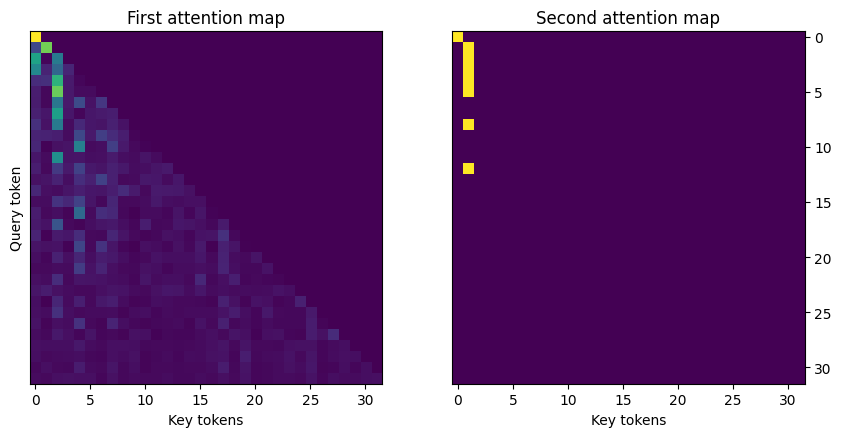

In [ ]:
poly_trainer.train(epochs=200)

Token Acc (ignore PAD): 10.88% | Seq Acc (unpadded exact): 10.88%


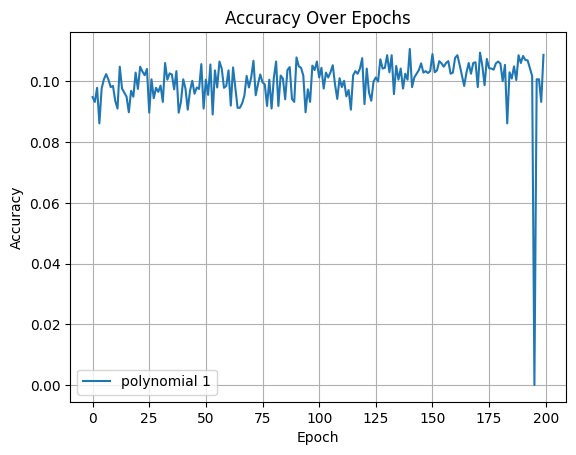

In [13]:
poly_trainer.evaluate()
poly_trainer.plot_accuracy()

In [14]:
xs1, xs2, ys, preds = [], [], [], []
for i in range(10):
    x, y = PolyDataset.generate(4, p=11)
    xs1.append(x[0].tolist())
    xs2.append(x[1].tolist())
    ys.append(y.item())
    preds.append(poly_trainer.predict(x))

df = pd.DataFrame({
    "x1": xs1,
    "x2": xs2,
    "y": ys,
    "prediction": preds
})

print(df)

             x1            x2   y  prediction
0        [0, 9]       [10, 7]   9           1
1          [10]           [5]   7          10
2     [9, 8, 4]     [3, 6, 7]   5           2
3       [10, 3]        [1, 0]   0          10
4  [7, 2, 2, 9]  [3, 8, 9, 8]   7          10
5        [6, 3]        [8, 9]  10          10
6           [2]           [0]   1           5
7           [3]           [0]   1           2
8    [1, 10, 9]    [0, 10, 4]   5           0
9           [2]           [6]   2           5


### Parity training

In [15]:
parity_trainer = poly_trainer.fork(task='parity')
parity_trainer.reset_optimizer()
parity_trainer.train(epochs=50)

Epoch 49 | Loss: 0.0676 | TokAcc(ignore PAD): 48.44% | Acc: 50.26%: 100%|██████████| 50/50 [03:14<00:00,  3.89s/it]


Token Acc (ignore PAD): 50.26% | Seq Acc (unpadded exact): 50.26%


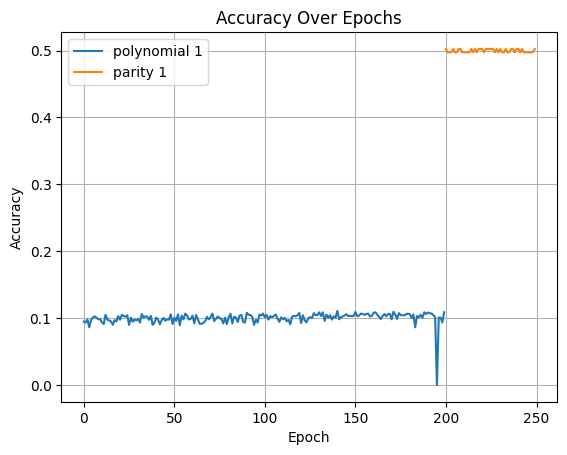

In [16]:
parity_trainer.evaluate()
parity_trainer.plot_accuracy()

In [17]:
xs, ys, preds = [], [], []
for i in range(10):
    x, y = ParityDataset.generate()
    xs.append(x)
    ys.append(y)
    preds.append(parity_trainer.predict(x))

df = pd.DataFrame({
    "bits": xs,
    "parity": ys,
    "prediction": preds
})

print(df)

                                                bits  parity  prediction
0  [1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, ...       1           0
1  [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, ...       0           0
2  [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...       0           0
3  [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...       0           0
4  [0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, ...       1           0
5  [0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, ...       1           0
6  [1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, ...       0           0
7  [1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...       0           0
8  [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, ...       0           0
9  [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...       1           0


# Advanced Datasets to test

## Factorial training

### Direction: $ALG(x) = x!$

In [18]:
factorial_trainer = Trainer(config, 'factorial') #poly_trainer.fork(task='factorial')
#factorial_trainer.reset_optimizer()
factorial_trainer.train(epochs=200)

Epoch 199 | Loss: 0.0599 | TokAcc(ignore PAD): 97.47% | Acc: 97.38%: 100%|██████████| 200/200 [13:11<00:00,  3.96s/it]


Token Acc (ignore PAD): 97.38% | Seq Acc (unpadded exact): 30.42%


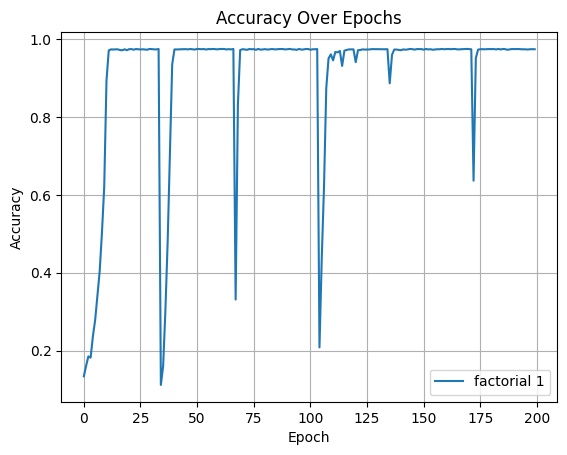

In [19]:
factorial_trainer.evaluate()
factorial_trainer.plot_accuracy()

In [20]:
xs, ys, preds = [], [], []
for i in range(10):
    x, y = FactorialDataset.generate(x=i+3)
    xs.append(x)
    ys.append(y)
    preds.append(factorial_trainer.predict(x))

df = pd.DataFrame({
    "x": xs,
    "y": ys,
    "prediction": preds
})

print(df)

    x          y  prediction
0   3          6           1
1   4         24          14
2   5        120         120
3   6        720         120
4   7       5040        1040
5   8      40320       10320
6   9     362880      162880
7  10    3628800     3628800
8  11   39916800    39916800
9  12  479001600   379001600


### Direction: $ALG(x!) = x$ (Factorial inversion)

In [21]:
factorial_inv_trainer = Trainer(config, task='factorial', inversion=True)  #poly_trainer.fork
#factorial_inv_trainer.reset_optimizer()
factorial_inv_trainer.train(epochs=200)

Epoch 199 | Loss: 0.2401 | TokAcc(ignore PAD): 43.80% | Acc: 41.75%: 100%|██████████| 200/200 [13:20<00:00,  4.00s/it]


Token Acc (ignore PAD): 41.75% | Seq Acc (unpadded exact): 12.50%


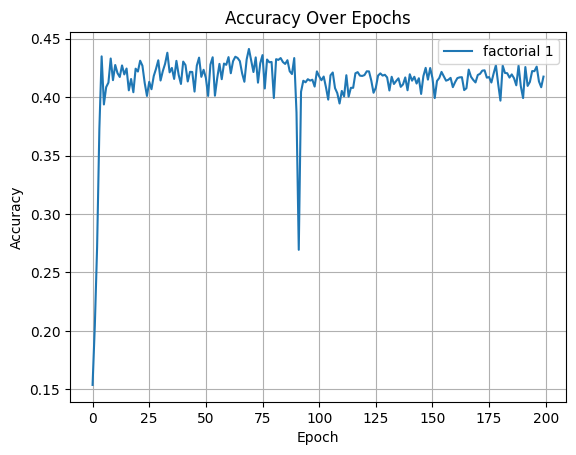

In [22]:
factorial_inv_trainer.evaluate()
factorial_inv_trainer.plot_accuracy()

In [23]:
xs, ys, preds = [], [], []
for i in range(10):
    x, y = FactorialDataset.generate(x=i+3)
    xs.append(x)
    ys.append(y)
    preds.append(factorial_inv_trainer.predict(y))

df = pd.DataFrame({
    "y": ys,
    "x": xs,
    "prediction": preds
})

print(df)

           y   x  prediction
0          6   3           4
1         24   4          46
2        120   5          92
3        720   6           5
4       5040   7          61
5      40320   8          56
6     362880   9          17
7    3628800  10          17
8   39916800  11          13
9  479001600  12          52


## Fibonacci training

### Direction: $ALG(x) = Fibonacci(x)$

In [24]:
fibonacci_trainer = Trainer(config=config, task="fibonacci") #poly_trainer.fork(task='fibonacci')
#fibonacci_trainer.reset_optimizer()
fibonacci_trainer.train(epochs=200)

Epoch 199 | Loss: 0.1483 | TokAcc(ignore PAD): 94.13% | Acc: 94.69%: 100%|██████████| 200/200 [13:02<00:00,  3.91s/it]


Token Acc (ignore PAD): 94.69% | Seq Acc (unpadded exact): 5.49%


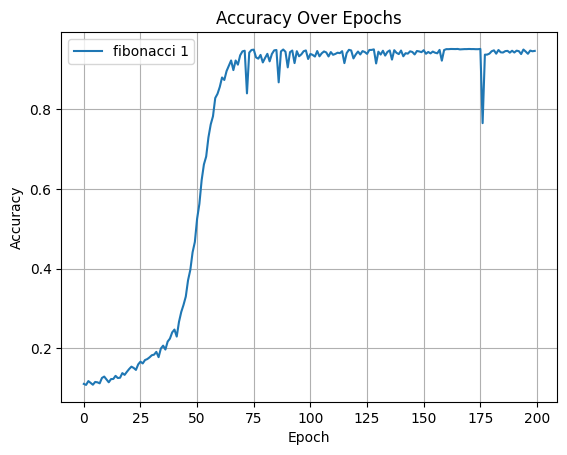

In [25]:
fibonacci_trainer.evaluate()
fibonacci_trainer.plot_accuracy()

In [26]:
xs, ys, preds = [], [], []
for i in range(30):
    x, y = FibonacciDataset.generate(x=i+3)
    xs.append(x)
    ys.append(y)
    preds.append(fibonacci_trainer.predict(x))

df = pd.DataFrame({
    "x": xs,
    "y": ys,
    "prediction": preds
})

print(df)

     x        y  prediction
0    3        2           1
1    4        3           2
2    5        5           1
3    6        8           1
4    7       13          13
5    8       21          11
6    9       34          14
7   10       55          16
8   11       89          18
9   12      144         164
10  13      233         173
11  14      377         117
12  15      610         160
13  16      987         127
14  17     1597        1397
15  18     2584        1884
16  19     4181        1681
17  20     6765        1165
18  21    10946       10946
19  22    17711       12711
20  23    28657       13657
21  24    46368       16368
22  25    75025       17025
23  26   121393      161393
24  27   196418      116418
25  28   317811      167811
26  29   514229      124229
27  30   832040      142040
28  31  1346269     1046269
29  32  2178309     1378309


Epoch 199 | Loss: 0.0591 | TokAcc(ignore PAD): 97.41% | Acc: 97.41%: 100%|██████████| 200/200 [12:42<00:00,  3.81s/it]


Token Acc (ignore PAD): 97.41% | Seq Acc (unpadded exact): 31.47%


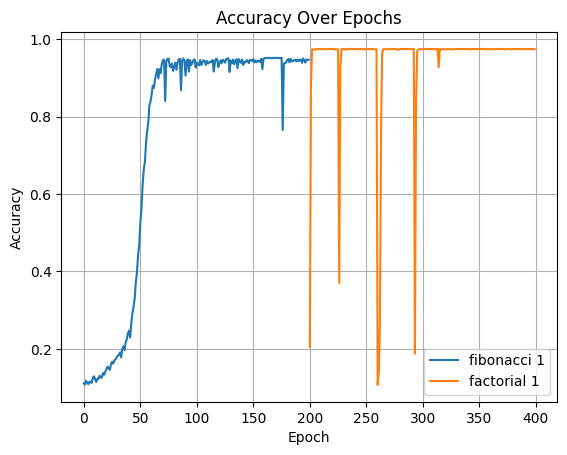

In [27]:
af_factorial_trainer = fibonacci_trainer.fork(task='factorial')
af_factorial_trainer.reset_optimizer()
af_factorial_trainer.train(epochs=200)
af_factorial_trainer.evaluate()
af_factorial_trainer.plot_accuracy()

In [32]:
xs, ys, preds = [], [], []
for i in range(10):
    x, y = FactorialDataset.generate(x=i+100)
    xs.append(x)
    ys.append(y)
    preds.append(af_factorial_trainer.predict(x))

df = pd.DataFrame({
    "x": xs,
    "y": ys,
    "prediction": preds
})

print(df)

     x                                                  y  \
0  100  9332621544394415268169923885626670049071596826...   
1  101  9425947759838359420851623124482936749562312794...   
2  102  9614466715035126609268655586972595484553559050...   
3  103  9902900716486180407546715254581773349090165822...   
4  104  1029901674514562762384858386476504428305377245...   
5  105  1081396758240290900504101305800329649720646107...   
6  106  1146280563734708354534347384148349428703884874...   
7  107  1226520203196137939351751701038733888713156815...   
8  108  1324641819451828974499891837121832599810209360...   
9  109  1443859583202493582204882102462797533793128203...   

                         prediction  
0  36326215443944152681699238856266  
1  36296225443944152681699238856268  
2        36328215443441526816992852  
3   3622628544344152681699238856266  
4  36226225443944152681699238856266  
5  36226215443944152681699238856266  
6  36226225443944152681699238856262  
7  362682254439441526816

### Direction: $ALG(Fibonacci(x)) = x$ (Fibonacci inversion)

In [29]:
fibonacci_inv_trainer = Trainer(config, task='fibonacci', inversion=True) #poly_trainer.fork
#fibonacci_inv_trainer.reset_optimizer()
fibonacci_inv_trainer.train(epochs=200)

Epoch 199 | Loss: 0.4045 | TokAcc(ignore PAD): 31.38% | Acc: 33.42%: 100%|██████████| 200/200 [12:56<00:00,  3.88s/it]


Token Acc (ignore PAD): 33.42% | Seq Acc (unpadded exact): 3.04%


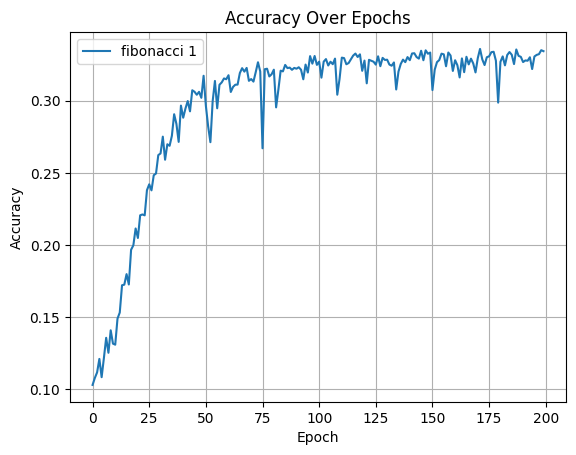

In [30]:
fibonacci_inv_trainer.evaluate()
fibonacci_inv_trainer.plot_accuracy()

In [31]:
xs, ys, preds = [], [], []
for i in range(30):
    x, y = FibonacciDataset.generate(x=i+3)
    xs.append(x)
    ys.append(y)
    preds.append(fibonacci_inv_trainer.predict(y))

df = pd.DataFrame({
    "y": ys,
    "x": xs,
    "prediction": preds
})

print(df)

          y   x  prediction
0         2   3           9
1         3   4           1
2         5   5           6
3         8   6           6
4        13   7          64
5        21   8          92
6        34   9          12
7        55  10          66
8        89  11          61
9       144  12         694
10      233  13         925
11      377  14          10
12      610  15          32
13      987  16          16
14     1597  17         602
15     2584  18         903
16     4181  19          46
17     6765  20          36
18    10946  21         603
19    17711  22         664
20    28657  23         908
21    46368  24         449
22    75025  25          62
23   121393  26         663
24   196418  27         674
25   317811  28         113
26   514229  29          66
27   832040  30          60
28  1346269  31         641
29  2178309  32         922
